In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import argrelextrema
from tqdm import tqdm
from scipy.special import factorial

# Set rcParams to customize tick labels and spines
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12

In [ ]:
# source_directory = f"D:/Courses/Uclouvain/thesis/code/these_Colin/seismogram_curve_extraction/data/ground_truths/overlap_20_images/"
source_directory = f"D:/Courses/Uclouvain/thesis/code/these_Colin/seismogram_curve_extraction/results/sBE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1_50_50_50_50_0-0_bw_0-1_864-0/"

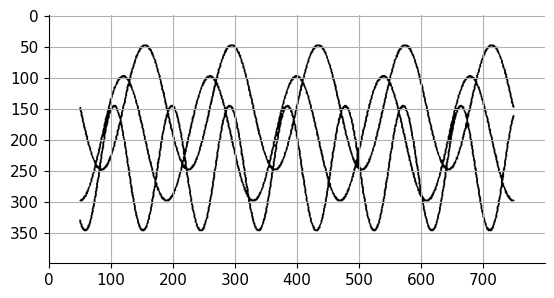

In [3]:
def load_images_from_folder(folder, N_show):
    # set N_show to 0 not to show any images
    saved_images = []  # List to store images
    count = 0
    for image_file in os.listdir(folder):
        if image_file.endswith('_binary.jpg'):
            image_file = os.path.join(folder, image_file)
            saved_images.append(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE))
            if count < N_show:
                plt.imshow(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE), cmap='gray')
                plt.show()
                count += 1

    return np.array(saved_images)

saved_images = load_images_from_folder(source_directory, 3)


In [4]:
# Get the ROI of the images
def get_roi(image):
    temp_image = - (image - np.max(image))
    # Get the row and column indices of the non-zero elements
    rows, cols = np.nonzero(temp_image)
    # Get the minimum and maximum row and column indices
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    # Get the ROI of the image
    roi = image[min_row:max_row + 1, min_col:max_col + 1]
    return roi

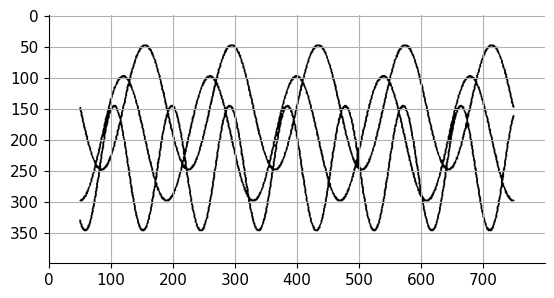

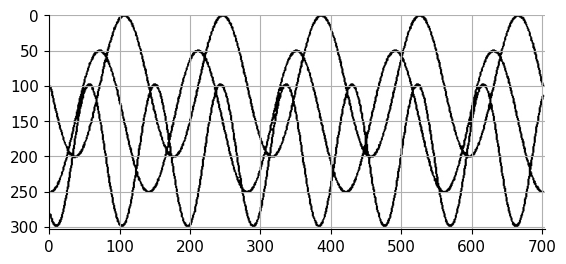

In [5]:
plt.imshow(saved_images[0], cmap='gray')
plt.show()

# Get the ROI of all the images
new_saved_images = []
for image in saved_images:
    new_saved_images.append(np.array(get_roi(image)))

saved_images = new_saved_images

plt.imshow(saved_images[0], cmap='gray')
plt.show()

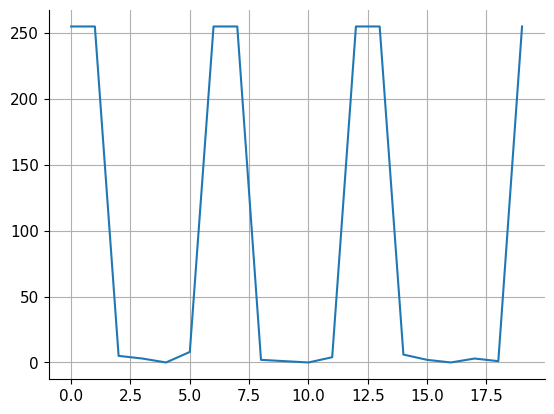

Number of connected components: 3
Average thickness: 4.333333333333333


In [6]:
def count_components_and_avg_thickness(arr, threshold=10):
    """
    Counts the number of connected components where values are close to 0 
    and computes the average thickness.

    Parameters:
    - arr: 1D numpy array containing grayscale values (0 to 255).
    - threshold: Defines what is considered "close to 0" (default: 10).

    Returns:
    - count: Number of connected components.
    - avg_thickness: Average thickness of components.
    """
    count = 0
    thicknesses = []
    n = len(arr)
    
    i = 0
    while i < n:
        if arr[i] < threshold:  # Found a new component (close to 0)
            count += 1
            start = i
            while i < n and arr[i] < threshold:  # Continue until background (255)
                i += 1
            thicknesses.append(i - start)
        else:
            i += 1

    avg_thickness = np.mean(thicknesses) if thicknesses else 0
    return count, avg_thickness

# Example usage
binary_array = np.array([255, 255, 5, 3, 0, 8, 255, 255, 2, 1, 0, 4, 255, 255, 6, 2, 0, 3, 1, 255])
num_components, avg_thickness = count_components_and_avg_thickness(binary_array)

plt.plot(binary_array)
plt.show()

print(f"Number of connected components: {num_components}")
print(f"Average thickness: {avg_thickness}")


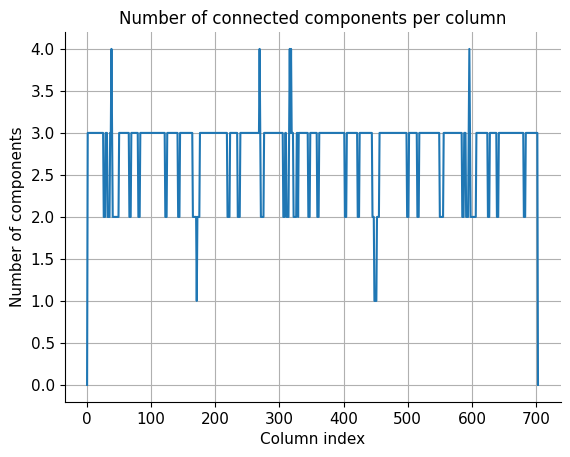

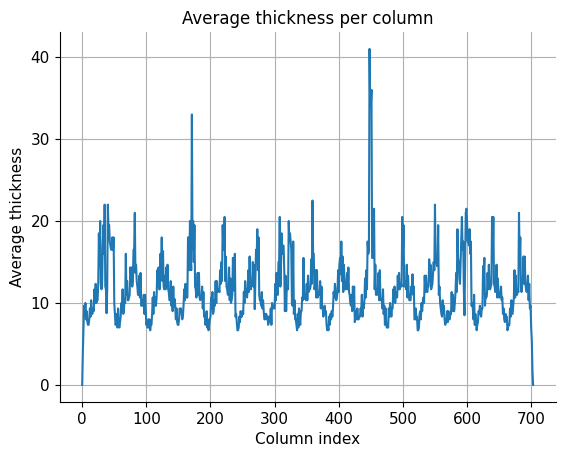

Average number of components: 3 VS true value is 5
Average thickness: 12 VS true value is 15


In [7]:
# apply to the columns of the image and compute the average thickness, average number of components
N_components = []
thickness = []

for i in range(saved_images[0].shape[1]):
    n, t = count_components_and_avg_thickness(saved_images[0][:, i])
    N_components.append(n)
    thickness.append(t)

plt.plot(N_components)
plt.title("Number of connected components per column")
plt.xlabel("Column index")
plt.ylabel("Number of components")
plt.show()

plt.plot(thickness)
plt.title("Average thickness per column")
plt.xlabel("Column index")
plt.ylabel("Average thickness")
plt.show()

# compute the average thickness and number of components for all images by ignoring the columns with no components
N_components = np.array(N_components)
thickness = np.array(thickness)
N_components = N_components[N_components > 1e-6]
thickness = thickness[thickness > 1e-6]

avg_N_components = int(np.round(np.mean(N_components)))
avg_thickness = int(np.round(np.mean(thickness)))
print(f"Average number of components: {avg_N_components} VS true value is 5")
print(f"Average thickness: {avg_thickness} VS true value is 15")


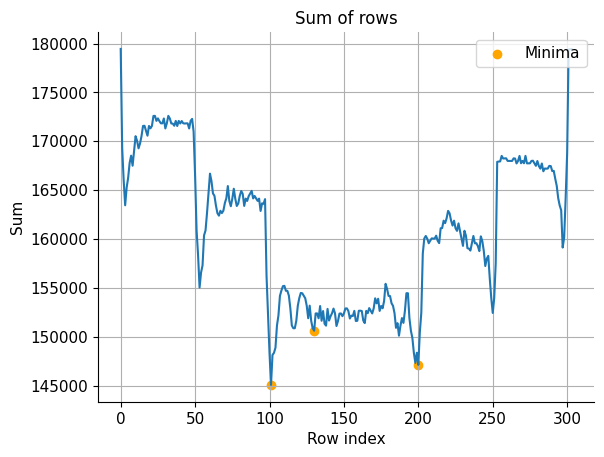

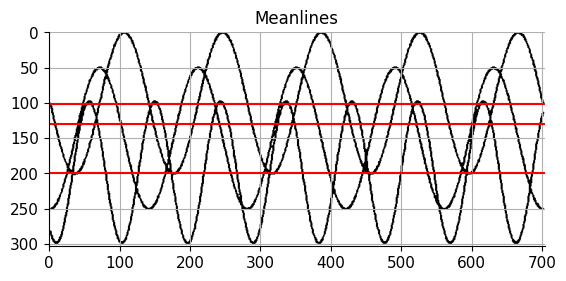

In [8]:
# find the meanlines of each curves in the image
# sum the rows of the image
sum_rows = np.sum(saved_images[0], axis=1)

# Find local minima
min_indices = argrelextrema(sum_rows, np.less, order=10)[0]
sorted_minima = min_indices[np.argsort(sum_rows[min_indices])]

plt.plot(sum_rows)
plt.scatter(sorted_minima[:avg_N_components], sum_rows[sorted_minima[:avg_N_components]], color='orange', label="Minima")
plt.legend()
plt.title("Sum of rows")
plt.xlabel("Row index")
plt.ylabel("Sum")
plt.show()

# The meanlines are the num_components rows with the minimum sum
meanlines = sorted_minima[:avg_N_components]

plt.imshow(saved_images[0], cmap='gray')
for meanline in meanlines:
    plt.axhline(meanline, color='r')
plt.title("Meanlines")
plt.show()

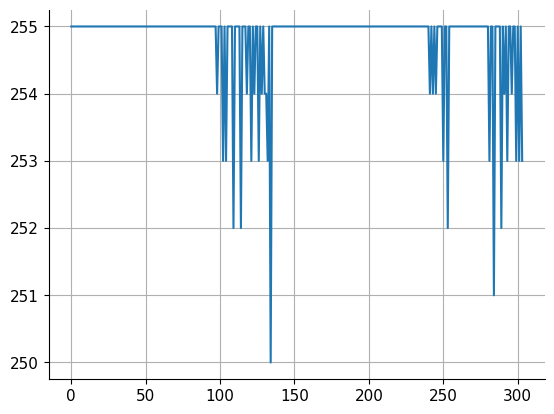

In [9]:
# plot one column of the image
plt.plot(saved_images[0][:, 0])
plt.show()

In [10]:
# Instead use the first column pixels to find the starting points of the N_components curves : X_0 for KF
# Also find the std of the standard deviation of the pixels in the first column to initialize P_0 for KF
X_0 = [50, 200, 300]
P_0 = [0, 0, 0]

# TODO


In [11]:
# Implement the Kalman Filter to track the curves around the meanlines

# Define the prediction step
def predict(X, P, A, Q):
    # check if X has 1 or 2 dimension(s)
    if len(X.shape) == 1:
        X = A @ X
        P = A @ P @ A.T + Q
    else:
        for i in range(X.shape[0]):
            X[i] = A @ X[i]
            P[i] = A @ P[i] @ A.T + Q
        # X = (A @ X.T).T  # Batch multiply all rows of X at once
        # P = A @ P @ A.T + Q  # Assuming P is (N, M, M), use batch multiplication
    return X, P

def  weighted_update(X, P, Z, H, R, P_fp=0):
    """
    Perform the Kalman filter update step using the JPDA approach for multiple traces.

    Args:
        X (np.ndarray): Shape (N, n, 1) - Predicted state estimates for N traces.
        P (np.ndarray): Shape (N, n, n) - Predicted covariance matrices for N traces.
        Z (np.ndarray): Shape (M, m, 1) - Measurements for M detections.
        H (np.ndarray): Shape (m, n) - Observation matrix.
        R (np.ndarray): Shape (m, m) - Measurement noise covariance.

    Returns:
        X_updated (np.ndarray): Shape (N, n, 1) - Updated state estimates.
        P_updated (np.ndarray): Shape (N, n, n) - Updated covariance matrices.
    """
    # print("X shape", X.shape)
    # print("P shape", P.shape)
    # print("Z shape", Z.shape)
    # print("H shape", H.shape)
    # print("R shape", R.shape)
    N, n = X.shape  # Number of traces, state dimension
    M = Z.shape[0]      # Number of measurements
    # m = Z.shape[1]      # Measurement dimension
    m = 1
    
    X_updated = np.copy(X)
    P_updated = np.copy(P)
    
    # Compute innovation covariance and Kalman gains
    S = np.zeros((N, m, m))  # Innovation covariance for each trace
    K = np.zeros((N, n, m))  # Kalman gain for each trace
    for i in range(N):
        S[i] = H @ P[i] @ H.T + R  # Innovation covariance
        if (S[i]).shape[0] == (S[i]).shape[1] == 1: K[i] = (P[i] @ H.T) / S[i]
        else: K[i] = np.linalg.solve(S[i], P[i] @ H.T)  
        # K[i] = P[i] @ H.T @ np.linalg.inv(S[i])  # Kalman gain
    # print("K shape", K.shape)
    # print("S shape", S.shape)

    # Compute association probabilities β_ij using Mahalanobis distance
    beta = np.zeros((N, M))
    likelihoods = np.zeros((N, M))

    for i in range(N):
        for j in range(M):
            residual = Z[j] - H @ X[i]  # Innovation (measurement residual)
            mahalanobis_dist = residual.T @ np.linalg.inv(S[i]) @ residual  # Mahalanobis distance
            likelihoods[i, j] = np.exp(-0.5 * mahalanobis_dist) / np.sqrt((2*np.pi)**m*np.linalg.det(S[i])**2) # USER

    # Normalize probabilities
    for i in range(N):
        beta[i, :] = likelihoods[i, :] / (np.sum(likelihoods[i, :]) + P_fp)  # Avoid division by zero
    # print(beta.sum(axis=1), beta.shape)

    # Update states using weighted innovation
    # print("N",N)
    # print("K", K)
    # print("-------------------")
    # print("b", np.sum(beta, axis=1))
    # print("-------------------")
    for i in range(N):
        # print(i)
        weighted_innovation = np.zeros((m, 1))
        for j in range(M):
            weighted_innovation += beta[i, j] * (Z[j] - H @ X[i])
        # print("weighted_innovation", weighted_innovation)
        # print("-------------------")
        # Update state and covariance
        beta_i = np.sum(beta[i, :])
        # print(X[i])
        # print(K[i], "K", K.shape)
        # print(weighted_innovation)
        # print("tt", "K", K[i].shape, "weighted_innovation", weighted_innovation.shape, (K[i] @ weighted_innovation).shape)
        X_updated[i] = X[i] + (K[i] @ weighted_innovation).ravel()
        temp = (np.eye(n) - beta_i * K[i] @ H)
        P_updated[i] = temp @ P[i] @ temp.T + K[i] @ (np.sum(beta[i, :]**2) * R) @ K[i].T
    # print("X_updated shape", X_updated.shape)
    # print("P_updated shape", P_updated.shape)


    return X_updated, P_updated, beta

In [12]:
# Define the state transition matrix

def state_transition_matrix(degree, Delta):
    """
    Generates the state transition matrix A for a given system degree.
    
    Parameters:
        degree (int): The number of state variables (e.g., 3 for acceleration, 5 for snap).
        Delta (float): Time step.
    
    Returns:
        np.array: State transition matrix of shape (degree, degree).
    """
    A = np.zeros((degree, degree))
    for i in range(degree):
        for j in range(i + 1):
            A[j,i] = (Delta ** (i - j)) / factorial(i - j)
    
    return A

Delta = 0.3 # Time step [pixels] USER
degree = 5 # USER

# A = np.array([[1, Delta, Delta**2/2],
#               [0, 1, Delta],
#               [0, 0, 1]]) 
A = state_transition_matrix(degree, Delta)
print(A)  

H = np.zeros((1, degree))
H[0, 0] = 1  # Only measure the position

# Define the process noise covariance matrix
sigma_p = 0.001
sigma_v = 0.001
sigma_a = 0.01  # Acceleration noise standard deviation
sigma_j = 0.01  # Jerk noise standard deviation

Q = np.zeros((degree, degree))
Q[0, 0] = sigma_p**2  # Process noise in position
Q[1, 1] = sigma_v**2  # Process noise in velocity
Q[2, 2] = sigma_a**2  # Process noise in acceleration
Q[3, 3] = sigma_j**2  # Process noise in jerk
# Q = np.eye(degree) * 0.001

# Define the measurement noise covariance matrix
sigma_z = 0.5  # Measurement noise standard deviation
R = np.array([[sigma_z**2]])

# Initialize the state and covariance
X = np.zeros((avg_N_components, degree))  # State: [position, velocity, acceleration, jerk, snap]
X[:, 0] = X_0  # Initial position

P = np.zeros((avg_N_components, degree, degree))  # State covariance matrix
P[:, 0, 0] = 0  # Position variance
P[:, 1, 1] = 1  # Velocity variance
P[:, 2, 2] = 1  # Acceleration variance
P[:, 3, 3] = 1  # Jerk variance (new)
P[:, 4, 4] = 1  # Snap variance (new)

[[1.000e+00 3.000e-01 4.500e-02 4.500e-03 3.375e-04]
 [0.000e+00 1.000e+00 3.000e-01 4.500e-02 4.500e-03]
 [0.000e+00 0.000e+00 1.000e+00 3.000e-01 4.500e-02]
 [0.000e+00 0.000e+00 0.000e+00 1.000e+00 3.000e-01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00]]


In [13]:
sel = 0 # selected image


In [14]:
# Now we can apply the Kalman filter to track the curves around the meanlines

# Initialize the list of estimated positions
estimated_positions_weighted = [[X[i, 0]] for i in range(avg_N_components)]

In [15]:
### 
# Weighted Kalman filter
###
X_weighted = np.copy(X)
P_weighted = np.copy(P)
tresh = 1e-2

for k in tqdm(range(1, saved_images[sel].shape[1]), desc="Processing columns"):

    col = saved_images[sel][:, k].astype(np.float64)
    if col.max() - col.min() > 0: col /= col.max() - col.min()
    # find the 0 value pixels, with a given treshold
    measurements = np.where(col < tresh)[0]

    # Predict
    X_w, P_w = predict(X_weighted, P_weighted, A, Q)
    # Weighted Update
    X_weighted, P_weighted, beta = weighted_update(X_w, P_w, measurements, H, R)
    # print(X_weighted)
    for i in range(avg_N_components):
        # Save the estimated position
        estimated_positions_weighted[i].append(X_weighted[i, 0])

Processing columns:   0%|          | 0/703 [00:00<?, ?it/s]C:\Users\Colin\AppData\Local\Temp\ipykernel_6908\3850235898.py:68: RuntimeWarning: invalid value encountered in divide
  beta[i, :] = likelihoods[i, :] / (np.sum(likelihoods[i, :]) + P_fp)  # Avoid division by zero
c:\Users\Colin\miniconda3\envs\seismo_env\Lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
Processing columns: 100%|██████████| 703/703 [00:02<00:00, 281.42it/s]


[[50.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

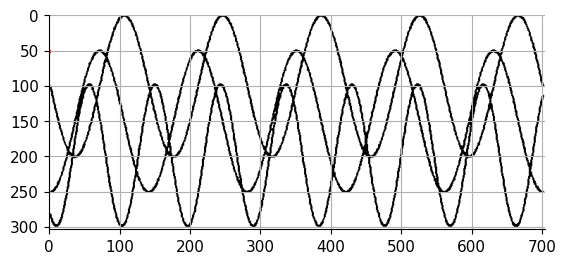

[[50.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

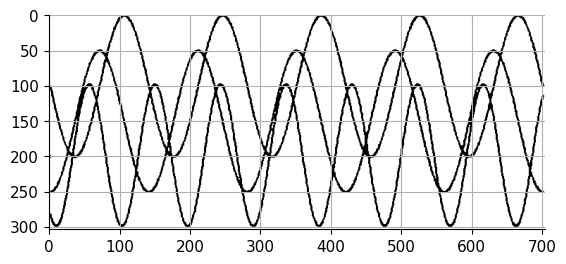

[[50.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

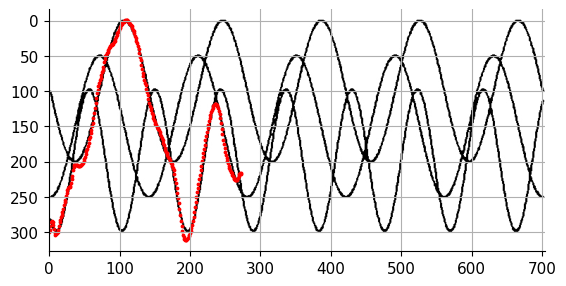

In [16]:
for i in range(avg_N_components):
    estimated_positions = estimated_positions_weighted[i]
    print(estimated_positions_weighted)

    # Plot the estimated positions
    plt.imshow(saved_images[sel], cmap='gray')

    estimated_positions = np.array(estimated_positions)
    print(estimated_positions.shape)

    i = 0
    if True:
        valid_indices = ~np.isnan(estimated_positions)  # Get valid (non-NaN) indices
        plt.scatter(np.where(valid_indices)[0], estimated_positions[valid_indices], color='r', s=3)

    plt.show()


    # comments:
    # better init, X_0 artificially given
    # all the black pixels in a specific column are considered as measurements
    # Problem, find good values for hyperparameters such as std